In [1]:
# Importing packages

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler
from torchsummary import summary

import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from PIL import Image

In [2]:
# Define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Define transformations 
train_transform = transforms.Compose([
    transforms.RandomCrop(96, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the dataset
trainset = datasets.STL10(root='../datasets', split='train', download=True, transform=train_transform)
valset = datasets.STL10(root='../datasets', split='train', download=True, transform=test_transform)
testset = datasets.STL10(root='../datasets', split='test', download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Create rotation function 
def rotate(image, degree=1):
    reshape = np.transpose(image, (1, 2, 0))
    rot_image = np.rot90(reshape, degree)
    return torch.Tensor(np.transpose(rot_image, (2, 0, 1)).copy())

In [5]:
train_x = trainset.data
train_y = trainset.labels
val_x = valset.data
val_y = valset.labels
test_x = testset.data
test_y = testset.labels

print(train_x.shape)
print(type(train_x))
print(train_y.shape)
print(type(train_y))

(5000, 3, 96, 96)
<class 'numpy.ndarray'>
(5000,)
<class 'numpy.ndarray'>


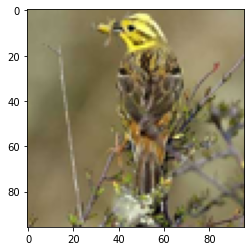

In [6]:
plt.imshow(np.transpose(train_x[0], (1, 2, 0)))

In [7]:
# # Expand x_train and y_train
# x_train_all = []
# y_train_all = []

# for inx in range(5000):
#     x_train_all.append(train_x[inx])
#     x_train_all.append(rotate(train_x[inx]))
#     x_train_all.append(rotate(train_x[inx], 2))
#     x_train_all.append(rotate(train_x[inx], 3))

#     for iny in range(4):
#         y_train_all.append((train_y[inx], iny))
        
# x_train_all = torch.Tensor(x_train_all)
# y_train_all = torch.Tensor(y_train_all)

In [8]:
# Expand X_train and y_train
X_train_all = []
y_train_all = []

for (x, y) in trainset:
    deg = np.random.randint(0, 4)
    X_train_all.append(x)
    y_train_all.append((y, 0))
    X_train_all.append(rotate(x, deg))
    y_train_all.append((y, deg))

In [9]:
len(X_train_all)

10000

In [10]:
# Define my dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
# Create DataLoader for the STL10 dataset
train_all_loader = DataLoader(MyDataset(X_train_all, y_train_all), batch_size=128, num_workers=2, 
                                          sampler=sampler.SubsetRandomSampler(range(8000)))

val_all_loader = DataLoader(MyDataset(X_train_all, y_train_all), batch_size=128, num_workers=2, 
                                          sampler=sampler.SubsetRandomSampler(range(8000, 10000)))

testloader = DataLoader(testset, batch_size=64, num_workers=2, shuffle=False)

In [12]:
for num, batch in enumerate(testloader):
    if num > 10:
        break
    images, labels = batch
    print(images, labels)

tensor([[[[ 0.7804,  0.7804,  0.7725,  ...,  0.7961,  0.7882,  0.7961],
          [ 0.7804,  0.7725,  0.7882,  ...,  0.7882,  0.7961,  0.7882],
          [ 0.7804,  0.7804,  0.7804,  ...,  0.7882,  0.7961,  0.7961],
          ...,
          [ 0.7412,  0.7804,  0.8118,  ...,  0.3333,  0.5373,  0.5608],
          [ 0.8275,  0.6706,  0.5843,  ...,  0.5922,  0.6157,  0.5216],
          [ 0.7569,  0.7647,  0.7569,  ...,  0.5373,  0.4039,  0.3647]],

         [[ 0.8431,  0.8431,  0.8510,  ...,  0.8275,  0.8353,  0.8431],
          [ 0.8431,  0.8431,  0.8431,  ...,  0.8275,  0.8275,  0.8353],
          [ 0.8431,  0.8510,  0.8510,  ...,  0.8275,  0.8275,  0.8275],
          ...,
          [ 0.3647,  0.4431,  0.4588,  ...,  0.1529,  0.2784,  0.3098],
          [ 0.5059,  0.3647,  0.2784,  ...,  0.3176,  0.3098,  0.2392],
          [ 0.4196,  0.4431,  0.4431,  ...,  0.2000,  0.1451,  0.0824]],

         [[ 0.8588,  0.8588,  0.8588,  ...,  0.8510,  0.8510,  0.8431],
          [ 0.8588,  0.8588,  

In [37]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, num_block=1):
        super(ResBlock, self).__init__()
        self.num_block = num_block
        self.layers = nn.ModuleList([])
        
        self.layers.append(nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride)
        ))
        self.layers.append(nn.Sequential  (
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=stride),
#             nn.GroupNorm(out_channel//4, out_channel),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, stride=1),
            nn.GroupNorm(out_channel//4, out_channel),
            nn.ReLU(inplace=True)
        ))
        
        for _ in range(1, num_block):
            self.layers.append(nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size=1, stride=1)
            ))
            self.layers.append(nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, stride=1),
#                 nn.GroupNorm(out_channel//4, out_channel),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, stride=1),
#                 nn.GroupNorm(out_channel//4, out_channel),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True)
            ))
    
    def forward(self, x):
        for i in range(self.num_block):
            x_identity = self.layers[2*i](x)
            x = self.layers[2*i+1](x)
            x = F.relu(x + x_identity, inplace=True) 
        
        return x

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
#         self.gn1 = nn.GroupNorm(4, 16)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.layers1 = ResBlock(32, 32, num_block=2)
        self.layers2 = ResBlock(32, 64, stride=2, num_block=2)
        self.layers3 = ResBlock(64, 128, stride=2, num_block=2)
        self.layers4 = ResBlock(128, 256, stride=2, num_block=2)
        
        self.avgpool1 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 10)
          
    def forward(self, x, theta = None):
        x = self.conv1(x)
#         x = self.gn1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.layers1(x)
        x = self.layers2(x)
        
        x1 = self.layers3(x)
        x1 = self.layers4(x1)
        x1 = self.avgpool1(x1)
        x1 = x1.view(-1, 256)
        x1 = self.fc1(x1)
        
        return x1


class JointResNet(nn.Module):
    def __init__(self):
        super(JointResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
#         self.gn1 = nn.GroupNorm(4, 16)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layers1 = ResBlock(64, 64, num_block=2)
        self.layers2 = ResBlock(64, 128, stride=2, num_block=2)
        self.layers3 = ResBlock(128, 256, stride=2, num_block=2)
        self.layers4_1 = ResBlock(256, 512, stride=2, num_block=2)
        self.layers4_2 = ResBlock(256, 512, stride=2, num_block=2)
        
        self.avgpool1 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 10)
        
        self.avgpool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc2 = nn.Linear(512, 4)
        
        
    def forward(self, x, theta = None):
        x = self.conv1(x)
#         x = self.gn1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.layers1(x)
        x = self.layers2(x)
        x = self.layers3(x)
        
        x1 = self.layers4_1(x)
        x1 = self.avgpool1(x1)
        x1 = x1.view(-1, 512)
        x1 = self.fc1(x1)
        
        x2 = self.layers4_2(x)
        x2 = self.avgpool2(x2)
        x2 = x2.view(-1, 512)
        x2 = self.fc2(x2)
        return x1, x2  

In [13]:
def check_accuracy_resnet(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    model.train() # set model back to train mode

def check_accuracy_jointresnet(loader, model):
    num_correct = 0
    rot_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            label = y[0].to(device=device)
            rot = y[1].to(device=device)
            out1, out2 = model(x)
            
            _, preds = out1.max(1)
            num_correct += (preds == label).sum()
            _, preds_rot = out2.max(1)
            rot_correct += (preds_rot == rot).sum()   
            num_samples += preds.size(0)
            
        acc = float(num_correct) / num_samples
        acc_rot = float(rot_correct) / num_samples
        print('classification acc: {:.3f}, rotation pred acc: {:.3f}'.format(acc, acc_rot))
    model.train() # set model back to train mode

## ResNet

In [19]:
# Define the loss functions
criterion = nn.CrossEntropyLoss()

# Initialize the model and define optimizer
model_resnet = ResNet().to(device)
optimizer = optim.SGD(model_resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

In [20]:
print(summary(model_resnet, (3, 96, 96)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 96, 96]          896
├─BatchNorm2d: 1-2                       [-1, 32, 96, 96]          64
├─ResBlock: 1-3                          [-1, 32, 96, 96]          --
|    └─ModuleList: 2                     []                        --
|    |    └─Sequential: 3-1              [-1, 32, 96, 96]          1,056
|    |    └─Sequential: 3-2              [-1, 32, 96, 96]          18,624
|    |    └─Sequential: 3-3              [-1, 32, 96, 96]          1,056
|    |    └─Sequential: 3-4              [-1, 32, 96, 96]          18,624
|    |    └─Sequential: 3-5              [-1, 32, 96, 96]          1,056
|    |    └─Sequential: 3-6              [-1, 32, 96, 96]          18,624
|    |    └─Sequential: 3-7              [-1, 32, 96, 96]          1,056
|    |    └─Sequential: 3-8              [-1, 32, 96, 96]          18,624
├─ResBlock: 1-4                          [-1, 64, 48, 48

In [21]:
trainloader = DataLoader(trainset, batch_size=128, num_workers=2, 
                                          sampler=sampler.SubsetRandomSampler(range(4000)))

valloader = DataLoader(valset, batch_size=128, num_workers=2, 
                                          sampler=sampler.SubsetRandomSampler(range(4000, 5000)))

In [22]:
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        out = model_resnet(images)

        # Compute the loss
        loss = criterion(out, labels)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()
        
#         # Update the scheduler
#         scheduler.step()
        
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}')
    
    # Update the scheduler
    scheduler.step()
    
    if (epoch+1) % 5 == 0:
        print('Training:')        
        check_accuracy_resnet(trainloader, model_resnet)    

        print('Validation:')        
        check_accuracy_resnet(valloader, model_resnet)

Epoch [1/100], Step [10/32], Loss: 2.3263
Epoch [1/100], Step [20/32], Loss: 1.9546
Epoch [1/100], Step [30/32], Loss: 1.7929
Epoch [2/100], Step [10/32], Loss: 1.7931
Epoch [2/100], Step [20/32], Loss: 1.8740
Epoch [2/100], Step [30/32], Loss: 1.7692
Epoch [3/100], Step [10/32], Loss: 1.6283
Epoch [3/100], Step [20/32], Loss: 1.5758
Epoch [3/100], Step [30/32], Loss: 1.6563
Epoch [4/100], Step [10/32], Loss: 1.5602
Epoch [4/100], Step [20/32], Loss: 1.4731
Epoch [4/100], Step [30/32], Loss: 1.7134
Epoch [5/100], Step [10/32], Loss: 1.6197
Epoch [5/100], Step [20/32], Loss: 1.4012
Epoch [5/100], Step [30/32], Loss: 1.4689
Training:
Got 1226 / 4000 correct (30.65)
Validation:
Got 295 / 1000 correct (29.50)
Epoch [6/100], Step [10/32], Loss: 1.5026
Epoch [6/100], Step [20/32], Loss: 1.3184
Epoch [6/100], Step [30/32], Loss: 1.4938
Epoch [7/100], Step [10/32], Loss: 1.4121
Epoch [7/100], Step [20/32], Loss: 1.4078
Epoch [7/100], Step [30/32], Loss: 1.3104
Epoch [8/100], Step [10/32], Loss

In [23]:
# Compute the accuracy on the test set
correct = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        labels = labels.to(torch.int64)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        out = model_resnet(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification: {:.2f} %'.format(100 * correct / total))

Accuracy for image classification: 72.86 %


In [28]:
# save the model
torch.save({
            'model_state_dict': model_resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'models/stl_resnet.pt')

## Joint Train

In [29]:
for batch in train_all_loader:
    # Unpack the batch into images and labels
    images, labels = batch

    # Do something with the batch
    print(images.shape)
    print(labels)

torch.Size([128, 3, 96, 96])
[tensor([2, 7, 8, 5, 4, 1, 0, 9, 1, 4, 1, 4, 8, 5, 9, 3, 3, 2, 2, 1, 2, 4, 7, 7,
        8, 7, 9, 7, 7, 2, 0, 0, 7, 3, 8, 9, 5, 5, 5, 3, 6, 2, 3, 7, 6, 7, 1, 1,
        0, 9, 6, 1, 0, 3, 2, 1, 5, 8, 1, 6, 4, 0, 0, 2, 9, 0, 5, 1, 5, 9, 4, 5,
        6, 6, 3, 5, 4, 4, 4, 6, 2, 6, 5, 4, 3, 8, 2, 0, 9, 3, 3, 9, 0, 8, 2, 9,
        9, 5, 0, 5, 0, 9, 4, 0, 4, 6, 2, 5, 0, 8, 8, 5, 9, 6, 7, 5, 2, 8, 3, 5,
        6, 3, 4, 7, 7, 7, 4, 2]), tensor([2, 0, 1, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0,
        0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 3, 1, 0, 0, 0, 2, 3, 2, 0,
        2, 2, 0, 3, 0, 0, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 2, 0, 3, 3, 0, 0, 1, 0, 2, 0,
        3, 0, 3, 0, 0, 0, 2, 3, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
        2, 2, 0, 1, 0, 0, 0, 3])]
torch.Size([128, 3, 96, 96])
[tensor([7, 2, 7, 3, 4, 5, 2, 7, 6, 0, 9, 8, 6, 3, 4, 8, 0, 6, 4, 2, 5, 7

In [46]:
# Define the loss functions
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()


# Initialize the model and define optimizer
model1 = JointResNet().to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-4)
scheduler = StepLR(optimizer1, step_size=30, gamma=0.1)
# optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

In [47]:
print(summary(model1, (3, 96, 96)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 96, 96]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 96, 96]          128
├─ResBlock: 1-3                          [-1, 64, 96, 96]          --
|    └─ModuleList: 2                     []                        --
|    |    └─Sequential: 3-1              [-1, 64, 96, 96]          4,160
|    |    └─Sequential: 3-2              [-1, 64, 96, 96]          74,112
|    |    └─Sequential: 3-3              [-1, 64, 96, 96]          4,160
|    |    └─Sequential: 3-4              [-1, 64, 96, 96]          74,112
├─ResBlock: 1-4                          [-1, 128, 48, 48]         --
|    └─ModuleList: 2                     []                        --
|    |    └─Sequential: 3-5              [-1, 128, 48, 48]         8,320
|    |    └─Sequential: 3-6              [-1, 128, 48, 48]         221,952
|    |    └─Sequential: 3-7              [-1, 128, 48, 48] 

In [48]:
# Train the model
num_epochs = 65
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_all_loader):
        labels_1 = labels[0]
        labels_2 = labels[1]
        images, labels_1, labels_2 = images.to(device), labels_1.to(device), labels_2.to(device)
        
        # Zero the gradients
        optimizer1.zero_grad()

        # Forward pass
        out1, out2 = model1(images)

        # Compute the loss
        loss1 = criterion1(out1, labels_1)
        loss2 = criterion2(out2, labels_2)
        loss = loss1 + loss2

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer1.step()
        
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_all_loader)}], Loss: {loss.item():.4f}')
    
    # Update the scheduler
#     scheduler.step()
    
    if (epoch+1) % 5 == 0:
        print('Training:')        
        check_accuracy_jointresnet(train_all_loader, model1)    

        print('Validation:')        
        check_accuracy_jointresnet(val_all_loader, model1)

Epoch [1/65], Step [10/63], Loss: 3.2488
Epoch [1/65], Step [20/63], Loss: 2.8534
Epoch [1/65], Step [30/63], Loss: 2.9884
Epoch [1/65], Step [40/63], Loss: 2.6029
Epoch [1/65], Step [50/63], Loss: 2.7730
Epoch [1/65], Step [60/63], Loss: 2.7685
Epoch [2/65], Step [10/63], Loss: 2.8888
Epoch [2/65], Step [20/63], Loss: 2.8066
Epoch [2/65], Step [30/63], Loss: 2.4443
Epoch [2/65], Step [40/63], Loss: 2.4681
Epoch [2/65], Step [50/63], Loss: 2.5496
Epoch [2/65], Step [60/63], Loss: 2.5723
Epoch [3/65], Step [10/63], Loss: 2.3716
Epoch [3/65], Step [20/63], Loss: 2.7217
Epoch [3/65], Step [30/63], Loss: 2.3974
Epoch [3/65], Step [40/63], Loss: 2.5361
Epoch [3/65], Step [50/63], Loss: 2.3913
Epoch [3/65], Step [60/63], Loss: 2.5582
Epoch [4/65], Step [10/63], Loss: 2.3986
Epoch [4/65], Step [20/63], Loss: 2.4113
Epoch [4/65], Step [30/63], Loss: 2.4782
Epoch [4/65], Step [40/63], Loss: 2.3987
Epoch [4/65], Step [50/63], Loss: 2.2749
Epoch [4/65], Step [60/63], Loss: 2.3357
Epoch [5/65], St

In [49]:
# Compute the accuracy on the test set
correct1 = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        out1, _ = model1(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct1 += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification: {:.2f} %'.format(100 * correct1 / total))

Accuracy for image classification: 60.33 %


In [50]:
# save the model
torch.save({
            'model_state_dict': model1.state_dict(),
            'optimizer_state_dict': optimizer1.state_dict(),
            }, 'models/stl_jointresnet2.pt')